In [1]:
!pip install git+https://github.com/brianbt/btorch
!pip install transformers
!pip install pip install datasets

  Cloning https://github.com/brianbt/btorch to /tmp/pip-req-build-5a9bzyx6
  Running command git clone --filter=blob:none --quiet https://github.com/brianbt/btorch /tmp/pip-req-build-5a9bzyx6
  Resolved https://github.com/brianbt/btorch to commit 467981f6eeb0f504330c83727217faeac680702f
  Preparing metadata (setup.py) ... done
  Created wheel for btorch: filename=btorch-0.0.1-py3-none-any.whl size=53134 sha256=6111a7d76506aa8b3414751f0e9f236db52cd2d228848ce2f66e7ce764348e57
  Stored in directory: /tmp/pip-ephem-wheel-cache-_xb602ko/wheels/fa/ef/1e/1248ce8683f1b6fd8e6552260da8c1dcfbb352d899fef03d72
Successfully built btorch


# Import

In [2]:
import torch
from tqdm import tqdm

# Btorch
import btorch
from btorch import nn
import btorch.nn.functional as F

# Hugging Face
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, AutoModel

# Load dataset

In [3]:
# https://huggingface.co/datasets/emotion
# this dataset have 6 classes
idx2label = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

dataset = load_dataset("emotion")
print(dataset)
# Lets check how one datapoint looks like
print(next(iter(dataset['train'])))

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
{'text': 'i didnt feel humiliated', 'label': 0}


# Create HuggingFace BERT 🤗 

In [4]:
#https://huggingface.co/bert-base-uncased
model_name = 'bert-base-uncased'

# You can check the config parameter options from the below links
#https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/configuration#transformers.PretrainedConfig
#https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/bert#transformers.BertConfig
config = AutoConfig.from_pretrained(
    model_name, 
    output_hidden_states = True,
    output_attention = True,
    hidden_dropout_prob = 0.2,
) 
print(config)

# Use above config to create our BERT model
pretrain_model = AutoModel.from_pretrained(
    model_name,
    config = config
)

# Create a BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## Quick tutor for tokenizer usgage

In [5]:
x = ['i didnt feel humiliated',
     'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
     'im grabbing a minute to post i feel greedy wrong']
y = [0,
     0,
     3]

In [115]:
# Since each data in one batch must have same size. We do padding and truncation such that the length is 10 for each sentence.
# The padding idx will be ``0``
# Tokenizer will append [CLS] and [SEP] in front and at back of the sentence.
# Then add [PAD] to make the entire length=max_length
tokens = tokenizer(x, padding=True, truncation=True, max_length=10)
display(tokens['input_ids'])


[[101, 1045, 2572, 6517, 102, 0, 0, 0, 0, 0],
 [101, 1045, 2572, 3407, 102, 0, 0, 0, 0, 0],
 [101, 1045, 3030, 3110, 3147, 1998, 2211, 3110, 2980, 102],
 [101, 2054, 1996, 17752, 2003, 2023, 102, 0, 0, 0],
 [101, 1045, 2123, 1005, 1056, 2729, 2054, 2017, 2079, 102],
 [101, 1045, 2293, 2017, 11910, 102, 0, 0, 0, 0],
 [101, 1045, 2293, 2017, 1999, 2296, 5304, 102, 0, 0]]

In [116]:
# Lets decode thosse index
[tokenizer.decode(i, padding=True, truncation=True, max_length=50) for i in tokens['input_ids']]

['[CLS] i am sad [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] i am happy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] i stopped feeling cold and began feeling hot [SEP]',
 '[CLS] what the heck is this [SEP] [PAD] [PAD] [PAD]',
 "[CLS] i don't care what you do [SEP]",
 '[CLS] i love you 3000 [SEP] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] i love you in every universe [SEP] [PAD] [PAD]']

In [117]:
# This is either 0 or 1.
# Remeber training data for BERT have two parts. 
# The first is indicated as 0, the second is indicated as 1
display(tokens['token_type_ids'])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [118]:
# This is attention mask.
# 0 means attention should be see those words
# Becoz those words is padded
display(tokens['attention_mask'])

[[1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]

## Quick tutor for BERT usgage

In [9]:
# here (N,T) is (3, max_length=10)
inputs = torch.tensor(tokens['input_ids'])
attn_masks = torch.tensor(tokens['attention_mask'])
# Hugging Face BERT will produce three thing for us base on how we set the config
out = pretrain_model(inputs, attention_mask=attn_masks)
print(out.keys())
# hidden_states is all the hidden_states #List[(N,T,D)]
# last_hidden_state is the last one
# pooler_output is output of tanh(Linear(last_hidden_state))
# torch.equal(out['hidden_states'][-1], out['last_hidden_state']) -> True
# Note that ``out['last_hidden_state'][:,0,:]`` is the CLS token and used for sentence level prediction

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])


In [10]:
out['last_hidden_state'][:,0,:].shape

torch.Size([3, 768])

In [11]:
out = pretrain_model(inputs, attention_mask=attn_masks)
torch.equal(out['hidden_states'][-1], out['last_hidden_state'])

True

# Wrap tokenizer and BERT in Btorch

Here we will freeze the pretrained BERT.  
Use the `last_hidden_state[:,0,:]` and `last_hidden_state[:,1:,:]` to perform multiHeadAttn.  
Pass the Attn_output to Linear layers and do classification.  
Use the attn_weight to find out which token has contribute to the classification task.



In [159]:
class Bert(nn.Module):
    def __init__(self, pretrain_model, tokenizer, classes, hidden_dim, freeze_pretrain=True):
        super(Bert, self).__init__()
        self.pretrain_model = pretrain_model
        self.tokenizer = tokenizer
        self.embed_size = pretrain_model.embeddings.word_embeddings.embedding_dim
        self.classes = classes
        self.hidden_dim = hidden_dim
        self.l1 = nn.Linear(self.embed_size, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, classes)
        self.last_attn = nn.MultiheadAttention(self.embed_size, 8, batch_first=True)
        if freeze_pretrain:
          btorch.utils.trainer.freeze(self.pretrain_model)
    def forward(self, x):
        x = self.tokenizer(x, padding=True, truncation=True, max_length=50)
        inputs = torch.tensor(x['input_ids'], device=self.device())
        attn_masks = torch.tensor(x['attention_mask'], device=self.device())
        pred = self.pretrain_model(inputs, attention_mask=attn_masks)
        last_hidden_CLS = pred['last_hidden_state'][:,0,:].unsqueeze(1) #(N,1,E)

        last_hidden_rest = pred['last_hidden_state'][:, 1:, :] # (N,T-1,E)
        # For a binary mask, a True value indicates that the corresponding key value will be ignored for the purpose of attention.
        # Here, we want to mask all padding
        atten_mask_pad = (inputs == 0)[:,1:] #(N,T-1)
        last_attn_out, last_attn_w = self.last_attn(last_hidden_CLS, last_hidden_rest, last_hidden_rest,
                                                    key_padding_mask=atten_mask_pad) #(N,1,E), (N,1,T-1)
        last_attn_out = last_attn_out.squeeze(1)
        out = torch.relu(self.l1(last_attn_out))
        out = self.l2(out)

        return out, last_attn_w
    
    @classmethod
    def train_epoch(cls, net, criterion, trainloader, optimizer, epoch_idx, device='cuda', config=None, **kwargs):
        """This is the very basic training function for one epoch. Override this function when necessary
            
        Returns:
            (float or dict): train_loss
        """
        net.train()
        train_loss = 0
        pbar = tqdm(enumerate(trainloader), total=len(trainloader), disable=(kwargs.get("verbose", 1) == 0))
        batch_idx = 1
        for batch_idx, (inputs) in pbar:
            text = inputs['text']
            targets = inputs['label'].to(net.device())
            optimizer.zero_grad()
            predicted = net(text)[0]
            loss = criterion(predicted, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            pbar.set_description(
                f"epoch {epoch_idx + 1} iter {batch_idx}: train loss {loss.item():.5f}.")
        return train_loss / (batch_idx + 1)

    @classmethod
    def test_epoch(cls, net, criterion, testloader, scoring=None, epoch_idx=0, device='cuda', config=None, **kwargs):
        """This is the very basic evaluating function for one epoch. Override this function when necessary

        Args:
            scoring (Callable, optional): A scoring function that take in ``y_true`` and ``model_output``.
              Usually, this is your evaluation metric, like accuracy.
              If provided, this method return a dict that include both loss and score.
              This scoring function should return the **sum** (set ``reduction=sum``) of the score of a batch.
              The function signature must be ``scoring(y_true=, model_output=)``.
              
        Returns:
            (float or dict): eval_loss
        """
        net.eval()
        test_loss = 0
        test_score = 0
        total = 0
        with torch.inference_mode():
            for batch_idx, (inputs) in enumerate(testloader):
                text = inputs['text']
                targets = inputs['label'].to(net.device())
                predicted = net(text)[0]
                loss = criterion(predicted, targets)
                test_loss += loss.item()
                if scoring is not None:
                    score = scoring(model_output=predicted, y_true=targets)
                    test_score += score
                total += len(text)
        if scoring is None:
            return test_loss / (batch_idx + 1)
        return {'loss': test_loss / (batch_idx + 1), 'score': test_score / total}

    @classmethod
    def predict_(cls, net, loader, device='cuda', config=None):
        """This is the very basic predicting function. Override this function when necessary
            
        Returns:
            (list or dict): predict results
        """
        net.to(device)
        net.eval()
        out = {}
        with torch.inference_mode():
            for batch_idx, (inputs) in enumerate(loader):
                text = inputs['text']
                predicted = net(text)[0]
                preds_raw = predicted.max(1)[1]
                for i in range(len(preds_raw)):
                    out[text[i]] = idx2label[preds_raw[i]]
        return out

In [160]:
def accuarcy(model_output, y_true, reduction='sum'):
    y_pred = model_output.max(1)[1]
    out = (y_pred == y_true).float().sum().item()
    return out
  
def predict_directly(net, x):
    out = net(x)
    preds_raw = out[0].max(1)[1]
    preds = {}
    for i in range(len(preds_raw)):
        preds[x[i]] = idx2label[preds_raw[i]]
    return preds

## Init Model

In [165]:
# Model
model = Bert(pretrain_model, tokenizer, 6, 512, freeze_pretrain=True)

# Loss & Optimizer & Config
model._config['max_epoch'] = 50
model._lossfn = nn.CrossEntropyLoss()
model._optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-3)
model._lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model._optimizer, model._config['max_epoch'])


# Set GPU
device = model.auto_gpu()

auto_gpu: using GPU (Tesla P100-PCIE-16GB)


In [166]:
# model.overfit_small_batch(dataset['train'])

In [167]:
# FIT
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
model.fit(dataset['train'], validation_data=dataset['validation'], batch_size=256, workers=4, scoring=accuarcy)

epoch 1 iter 62: train loss 1.08494.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 0: Training loss: 2.0569900917628456. Testing loss: {'loss': 1.0325260578393936, 'score': 0.64}


epoch 2 iter 62: train loss 0.74592.: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


Epoch 1: Training loss: 0.9623633377135746. Testing loss: {'loss': 0.7779072192907334, 'score': 0.7315}


epoch 3 iter 62: train loss 0.71218.: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 2: Training loss: 0.7620888314549885. Testing loss: {'loss': 0.5789363750070333, 'score': 0.8}


epoch 4 iter 62: train loss 0.62098.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 3: Training loss: 0.6865092336185394. Testing loss: {'loss': 0.5582062533944845, 'score': 0.8065}


epoch 5 iter 62: train loss 0.83022.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 4: Training loss: 0.6343393964426858. Testing loss: {'loss': 0.5231420259773731, 'score': 0.827}


epoch 6 iter 62: train loss 0.80069.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 5: Training loss: 0.6339042281347608. Testing loss: {'loss': 0.6424216949939727, 'score': 0.7785}


epoch 7 iter 62: train loss 0.68073.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 6: Training loss: 0.6413942074018811. Testing loss: {'loss': 0.480013039663434, 'score': 0.8205}


epoch 8 iter 62: train loss 0.55086.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 7: Training loss: 0.6275160728938995. Testing loss: {'loss': 0.516177862405777, 'score': 0.819}


epoch 9 iter 62: train loss 0.73070.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 8: Training loss: 0.6080800990263621. Testing loss: {'loss': 0.48831953866779804, 'score': 0.8295}


epoch 10 iter 62: train loss 0.64955.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 9: Training loss: 0.6073610437294793. Testing loss: {'loss': 0.5090148499011994, 'score': 0.8335}


epoch 11 iter 62: train loss 0.50002.: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 10: Training loss: 0.6085292720605456. Testing loss: {'loss': 0.5202297216877342, 'score': 0.8215}


epoch 12 iter 62: train loss 0.53114.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 11: Training loss: 0.5868179845431495. Testing loss: {'loss': 0.47013306224346163, 'score': 0.8345}


epoch 13 iter 62: train loss 0.55237.: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 12: Training loss: 0.5782815738329812. Testing loss: {'loss': 0.4999255694448948, 'score': 0.827}


epoch 14 iter 62: train loss 0.65309.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 13: Training loss: 0.6110917173680805. Testing loss: {'loss': 0.5010169743001461, 'score': 0.83}


epoch 15 iter 62: train loss 0.55696.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 14: Training loss: 0.5857805297488258. Testing loss: {'loss': 0.4452160780504346, 'score': 0.833}


epoch 16 iter 62: train loss 0.55538.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 15: Training loss: 0.5489872154735383. Testing loss: {'loss': 0.44282731814682486, 'score': 0.842}


epoch 17 iter 62: train loss 0.50922.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 16: Training loss: 0.5453284803837065. Testing loss: {'loss': 0.4171503846645355, 'score': 0.8445}


epoch 18 iter 62: train loss 0.44128.: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 17: Training loss: 0.5324177056077927. Testing loss: {'loss': 0.4893925714790821, 'score': 0.8325}


epoch 19 iter 62: train loss 0.52886.: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 18: Training loss: 0.531824114776793. Testing loss: {'loss': 0.4499558520168066, 'score': 0.8325}


epoch 20 iter 62: train loss 0.54330.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 19: Training loss: 0.5284544385614849. Testing loss: {'loss': 0.4385626876950264, 'score': 0.848}


epoch 21 iter 62: train loss 0.70328.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 20: Training loss: 0.5152408816511669. Testing loss: {'loss': 0.40073660691827534, 'score': 0.8635}


epoch 22 iter 62: train loss 0.43363.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 21: Training loss: 0.5042646688128275. Testing loss: {'loss': 0.41557471922785044, 'score': 0.8505}


epoch 23 iter 62: train loss 0.51574.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 22: Training loss: 0.5034566682482523. Testing loss: {'loss': 0.40832123352587224, 'score': 0.849}


epoch 24 iter 62: train loss 0.42868.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 23: Training loss: 0.5000937689864446. Testing loss: {'loss': 0.3787285519912839, 'score': 0.8655}


epoch 25 iter 62: train loss 0.42891.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 24: Training loss: 0.48062051383275833. Testing loss: {'loss': 0.3639151740819216, 'score': 0.8665}


epoch 26 iter 62: train loss 0.44759.: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 25: Training loss: 0.4788284448404161. Testing loss: {'loss': 0.39925728768855334, 'score': 0.857}


epoch 27 iter 62: train loss 0.44301.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 26: Training loss: 0.4806964449466221. Testing loss: {'loss': 0.37370242217928173, 'score': 0.8605}


epoch 28 iter 62: train loss 0.49104.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 27: Training loss: 0.46383692300508894. Testing loss: {'loss': 0.36458585078269246, 'score': 0.8675}


epoch 29 iter 62: train loss 0.39854.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 28: Training loss: 0.4614448523710644. Testing loss: {'loss': 0.3847260010614991, 'score': 0.8545}


epoch 30 iter 62: train loss 0.39200.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 29: Training loss: 0.4523891361932906. Testing loss: {'loss': 0.36460928690433503, 'score': 0.865}


epoch 31 iter 62: train loss 0.51373.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 30: Training loss: 0.4338012120080373. Testing loss: {'loss': 0.3535870287530124, 'score': 0.873}


epoch 32 iter 62: train loss 0.37449.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 31: Training loss: 0.4288468100721874. Testing loss: {'loss': 0.3721816559880972, 'score': 0.8665}


epoch 33 iter 62: train loss 0.37244.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 32: Training loss: 0.44002383001266965. Testing loss: {'loss': 0.3443417135551572, 'score': 0.8735}


epoch 34 iter 62: train loss 0.58814.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 33: Training loss: 0.4233548187074207. Testing loss: {'loss': 0.33603232650458814, 'score': 0.878}


epoch 35 iter 62: train loss 0.48231.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 34: Training loss: 0.4192131147498176. Testing loss: {'loss': 0.33284290612861517, 'score': 0.8775}


epoch 36 iter 62: train loss 0.50638.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 35: Training loss: 0.4199819176916092. Testing loss: {'loss': 0.3360182695686817, 'score': 0.881}


epoch 37 iter 62: train loss 0.36824.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 36: Training loss: 0.4067628246451181. Testing loss: {'loss': 0.3337050585746765, 'score': 0.8805}


epoch 38 iter 62: train loss 0.43327.: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch 37: Training loss: 0.4104379713535309. Testing loss: {'loss': 0.3359418839178979, 'score': 0.8775}


epoch 39 iter 62: train loss 0.45569.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 38: Training loss: 0.39657534871782574. Testing loss: {'loss': 0.3327499318830669, 'score': 0.8795}


epoch 40 iter 62: train loss 0.46396.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 39: Training loss: 0.3897934253253634. Testing loss: {'loss': 0.3269292581267655, 'score': 0.8805}


epoch 41 iter 62: train loss 0.34529.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 40: Training loss: 0.3916659099715097. Testing loss: {'loss': 0.3280732242334634, 'score': 0.8775}


epoch 42 iter 62: train loss 0.28414.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 41: Training loss: 0.3862795508097088. Testing loss: {'loss': 0.32136385383084415, 'score': 0.878}


epoch 43 iter 62: train loss 0.35586.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 42: Training loss: 0.3780378500620524. Testing loss: {'loss': 0.3203253073990345, 'score': 0.8835}


epoch 44 iter 62: train loss 0.49145.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 43: Training loss: 0.3752086777535696. Testing loss: {'loss': 0.3211224777549505, 'score': 0.8855}


epoch 45 iter 62: train loss 0.31170.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 44: Training loss: 0.3722893808569227. Testing loss: {'loss': 0.32892869898304344, 'score': 0.8815}


epoch 46 iter 62: train loss 0.38885.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 45: Training loss: 0.3725225920715029. Testing loss: {'loss': 0.32470373610034586, 'score': 0.8815}


epoch 47 iter 62: train loss 0.43722.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 46: Training loss: 0.36976195517040433. Testing loss: {'loss': 0.32001885280013087, 'score': 0.881}


epoch 48 iter 62: train loss 0.36591.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 47: Training loss: 0.3705322226834676. Testing loss: {'loss': 0.31797681203857064, 'score': 0.8845}


epoch 49 iter 62: train loss 0.30910.: 100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 48: Training loss: 0.3714562101023538. Testing loss: {'loss': 0.31834576167166234, 'score': 0.882}


epoch 50 iter 62: train loss 0.36368.: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 49: Training loss: 0.3632987860649351. Testing loss: {'loss': 0.31805257563106715, 'score': 0.8825}


In [168]:
model.evaluate(dataset['test'], scoring=accuarcy)

{'loss': 0.35295420640334485, 'score': 0.8695}

In [169]:
idx2label = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
x = ['I am sad', 'I am happy', 'i stopped feeling cold and began feeling hot', 
     'what the heck is this', "i don't care what you do", 'I love you 3000', 'I love you in every universe']
y = [0, 1, 3, 4, 3, 2, 2]
preds = predict_directly(model, x)
preds

{'I am sad': 'sadness',
 'I am happy': 'joy',
 'i stopped feeling cold and began feeling hot': 'anger',
 'what the heck is this': 'anger',
 "i don't care what you do": 'anger',
 'I love you 3000': 'anger',
 'I love you in every universe': 'joy'}

In [170]:
display(x)
x_token = tokenizer(x, padding=True, truncation=True, max_length=50)['input_ids']
display(x_token)
[tokenizer.decode(i, padding=True, truncation=True, max_length=50) for i in x_token]

['I am sad',
 'I am happy',
 'i stopped feeling cold and began feeling hot',
 'what the heck is this',
 "i don't care what you do",
 'I love you 3000',
 'I love you in every universe']

[[101, 1045, 2572, 6517, 102, 0, 0, 0, 0, 0],
 [101, 1045, 2572, 3407, 102, 0, 0, 0, 0, 0],
 [101, 1045, 3030, 3110, 3147, 1998, 2211, 3110, 2980, 102],
 [101, 2054, 1996, 17752, 2003, 2023, 102, 0, 0, 0],
 [101, 1045, 2123, 1005, 1056, 2729, 2054, 2017, 2079, 102],
 [101, 1045, 2293, 2017, 11910, 102, 0, 0, 0, 0],
 [101, 1045, 2293, 2017, 1999, 2296, 5304, 102, 0, 0]]

['[CLS] i am sad [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] i am happy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] i stopped feeling cold and began feeling hot [SEP]',
 '[CLS] what the heck is this [SEP] [PAD] [PAD] [PAD]',
 "[CLS] i don't care what you do [SEP]",
 '[CLS] i love you 3000 [SEP] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] i love you in every universe [SEP] [PAD] [PAD]']

Now we try to visualize which word contribute to the prediction.  
The higher attn weight tell us which token is important.  

0 0
Prediction: sadness. Ground-Truth: sadness
Prediction: 0. Ground-Truth: 0
I am sad
tensor([[0.1578, 0.1710, 0.5365, 0.1347, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)


[('0_i', 0.15775517),
 ('1_am', 0.17102455),
 ('2_sad', 0.5364807),
 ('3_<SEP>', 0.13473956)]

1 1
Prediction: joy. Ground-Truth: joy
Prediction: 1. Ground-Truth: 1
I am happy
tensor([[0.1410, 0.1838, 0.5409, 0.1343, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)


[('0_i', 0.1410408),
 ('1_am', 0.18379824),
 ('2_happy', 0.54090506),
 ('3_<SEP>', 0.13425589)]

3 2
Prediction: anger. Ground-Truth: anger
Prediction: 3. Ground-Truth: 3
i stopped feeling cold and began feeling hot
tensor([[0.1065, 0.0539, 0.0984, 0.3021, 0.0547, 0.0458, 0.0662, 0.2271, 0.0453]],
       device='cuda:0', grad_fn=<SelectBackward0>)


[('0_i', 0.10651444),
 ('1_stopped', 0.053923905),
 ('2_feeling', 0.098370075),
 ('3_cold', 0.30211294),
 ('4_and', 0.05466548),
 ('5_began', 0.045782972),
 ('6_feeling', 0.06616807),
 ('7_hot', 0.227149),
 ('8_<SEP>', 0.045313127)]

4 3
Prediction: anger. Ground-Truth: fear
Prediction: 3. Ground-Truth: 4
what the heck is this
tensor([[0.1934, 0.1510, 0.0834, 0.0933, 0.1443, 0.3346, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)


[('0_what', 0.1933646),
 ('1_the', 0.15098034),
 ('2_heck', 0.0834205),
 ('3_is', 0.09330206),
 ('4_this', 0.14433116),
 ('5_<SEP>', 0.33460134)]

3 4
Prediction: anger. Ground-Truth: anger
Prediction: 3. Ground-Truth: 3
i don't care what you do
tensor([[0.1084, 0.1278, 0.0810, 0.2095, 0.0771, 0.0779, 0.1910, 0.0801, 0.0471]],
       device='cuda:0', grad_fn=<SelectBackward0>)


[('0_i', 0.10840963),
 ('1_don', 0.127796),
 ("2_'", 0.08104326),
 ('3_t', 0.20953275),
 ('4_care', 0.07714799),
 ('5_what', 0.0778849),
 ('6_you', 0.19104694),
 ('7_do', 0.08006022),
 ('8_<SEP>', 0.047078326)]

2 5
Prediction: anger. Ground-Truth: love
Prediction: 3. Ground-Truth: 2
I love you 3000
tensor([[0.1016, 0.1810, 0.1585, 0.4649, 0.0939, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)


[('0_i', 0.101639844),
 ('1_love', 0.18103257),
 ('2_you', 0.1585277),
 ('3_3000', 0.46486628),
 ('4_<SEP>', 0.09393363)]

2 6
Prediction: joy. Ground-Truth: love
Prediction: 1. Ground-Truth: 2
I love you in every universe
tensor([[0.1173, 0.2317, 0.1491, 0.0643, 0.0644, 0.1161, 0.2571, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)


[('0_i', 0.117307425),
 ('1_love', 0.23168395),
 ('2_you', 0.14913762),
 ('3_in', 0.064302325),
 ('4_every', 0.06441341),
 ('5_universe', 0.116087526),
 ('6_<SEP>', 0.25706774)]

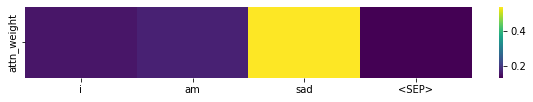

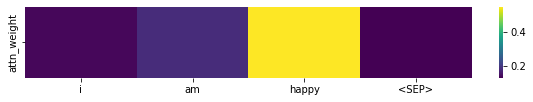

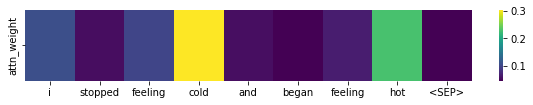

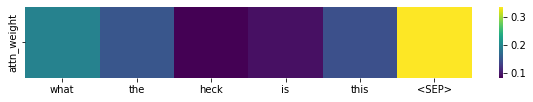

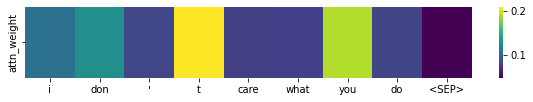

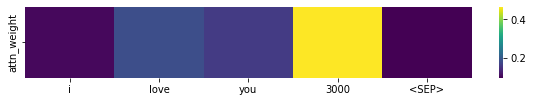

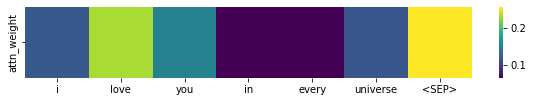

In [171]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt


pred, w = model(x)
for idx in range(0, len(x)):
    print(y[idx], idx)
    print(f"Prediction: {idx2label[pred[idx].argmax().item()]}. Ground-Truth: {idx2label[y[idx]]}")
    print(f"Prediction: {pred[idx].argmax().item()}. Ground-Truth: {y[idx]}")
    print(x[idx])
    print(w[idx])
    w_pure = w[idx][w[idx] !=0 ].cpu().detach().numpy()
    # Here tokenizer.tokenize will not help use add ['CLS']['SEP'], so we manually add it.
    # Remeber the weight doesn't contains ['CLS'], so we only add ['SEP'].
    tokens_pure = tokenizer.tokenize(x[idx])+['<SEP>']
    tokens = [f"{i}_{tokens_pure[i]}" for i in range(len(tokens_pure))]
    full = list(zip(tokens, w_pure))
    display(full)

    out = []
    out.append(list(full[0]))
    for i in range(1, len(full)):
        if full[i][0][:2] == '##':
            out[-1][0] += full[i][0][2:]
            out[-1][1] += full[i][1]
        else:
            out.append(list(full[i]))
    sorted(out, key=lambda out: out[1], reverse=True)

    
    df = pd.DataFrame(w_pure, index=tokens_pure, columns=['attn_weight'])
    plt.figure(figsize=(10,1.3))
    fig = sns.heatmap(df.T, fmt="g", cmap='viridis',xticklabels=tokens_pure)
    fig.get_figure().savefig("out.png",bbox_inches='tight', dpi=300) 
